In [211]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [319]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CustomerChurn_dataset.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Question 1


In [321]:
#dropping the Coustomer Id as it is irrelevant to the model training
df.drop('customerID', axis= 'columns',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


**Finding the nature of the values in each column**

In [322]:
for column in df.columns:
  print(column)
  print(df[column].unique())

gender
['Female' 'Male']
SeniorCitizen
[0 1]
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges
['29.85' '1889

Changing the "TotalCharges" column to float


In [323]:
df['TotalCharges']=pd.to_numeric(df.TotalCharges,errors='coerce')

In [324]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [325]:
#assigning the dependent and independent data to variables
Y= df['Churn']
X= df.drop('Churn', axis=1)

In [326]:

Y, labels = pd.factorize(df['Churn'])

# Create a DataFrame with the encoded target variable
Y = pd.DataFrame({'Churn': Y})


Data Cleaning for Internet and Phone Services
  - Merging similar data to one class

In [327]:
X.replace('No internet service','No',inplace=True)
X.replace('No phone service','No',inplace=True)

#viewing data now
for column in X.columns:
  print(column+ ': ')
  print(X[column].unique())

gender: 
['Female' 'Male']
SeniorCitizen: 
[0 1]
Partner: 
['Yes' 'No']
Dependents: 
['No' 'Yes']
tenure: 
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: 
['No' 'Yes']
MultipleLines: 
['No' 'Yes']
InternetService: 
['DSL' 'Fiber optic' 'No']
OnlineSecurity: 
['No' 'Yes']
OnlineBackup: 
['Yes' 'No']
DeviceProtection: 
['No' 'Yes']
TechSupport: 
['No' 'Yes']
StreamingTV: 
['No' 'Yes']
StreamingMovies: 
['No' 'Yes']
Contract: 
['Month-to-month' 'One year' 'Two year']
PaperlessBilling: 
['Yes' 'No']
PaymentMethod: 
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: 
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: 
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]


Encoding categorical features

In [328]:
categorical_columns = X.select_dtypes(include=['object']).columns
print(categorical_columns)

# Create a dictionary to store the mapping
mapping_dict = {}

# Use factorize to perform encoding and store the mapping
for column in categorical_columns:
    X[column], mapping = pd.factorize(X[column])
    mapping_dict[column] = dict(enumerate(mapping))

# Print the mapping dictionary
print("Mapping Dictionary:")
print(mapping_dict)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
Mapping Dictionary:
{'gender': {0: 'Female', 1: 'Male'}, 'Partner': {0: 'Yes', 1: 'No'}, 'Dependents': {0: 'No', 1: 'Yes'}, 'PhoneService': {0: 'No', 1: 'Yes'}, 'MultipleLines': {0: 'No', 1: 'Yes'}, 'InternetService': {0: 'DSL', 1: 'Fiber optic', 2: 'No'}, 'OnlineSecurity': {0: 'No', 1: 'Yes'}, 'OnlineBackup': {0: 'Yes', 1: 'No'}, 'DeviceProtection': {0: 'No', 1: 'Yes'}, 'TechSupport': {0: 'No', 1: 'Yes'}, 'StreamingTV': {0: 'No', 1: 'Yes'}, 'StreamingMovies': {0: 'No', 1: 'Yes'}, 'Contract': {0: 'Month-to-month', 1: 'One year', 2: 'Two year'}, 'PaperlessBilling': {0: 'Yes', 1: 'No'}, 'PaymentMethod': {0: 'Electronic check', 1: 'Mailed check', 2: 'Bank transfer (automatic)', 3: 'Credit card (automatic

Impute nas

In [268]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   float64
 1   SeniorCitizen     7043 non-null   float64
 2   Partner           7043 non-null   float64
 3   Dependents        7043 non-null   float64
 4   tenure            7043 non-null   float64
 5   PhoneService      7043 non-null   float64
 6   MultipleLines     7043 non-null   float64
 7   InternetService   7043 non-null   float64
 8   OnlineSecurity    7043 non-null   float64
 9   OnlineBackup      7043 non-null   float64
 10  DeviceProtection  7043 non-null   float64
 11  TechSupport       7043 non-null   float64
 12  StreamingTV       7043 non-null   float64
 13  StreamingMovies   7043 non-null   float64
 14  Contract          7043 non-null   float64
 15  PaperlessBilling  7043 non-null   float64
 16  PaymentMethod     7043 non-null   float64


Using Select KBest to extract relevant features that relate to churning

In [269]:
select= SelectKBest(score_func=chi2,k=7)
X_selected = select.fit_transform(X,Y)

filter = select.get_support()
features = X.columns

print("Selected best 7 features:")
print(features[filter])
print(X_selected)

Selected best 7 features:
Index(['tenure', 'OnlineSecurity', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
[[1.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 2.9850e+01 2.9850e+01]
 [3.4000e+01 1.0000e+00 1.0000e+00 ... 1.0000e+00 5.6950e+01 1.8895e+03]
 [2.0000e+00 1.0000e+00 0.0000e+00 ... 1.0000e+00 5.3850e+01 1.0815e+02]
 ...
 [1.1000e+01 1.0000e+00 0.0000e+00 ... 0.0000e+00 2.9600e+01 3.4645e+02]
 [4.0000e+00 0.0000e+00 0.0000e+00 ... 1.0000e+00 7.4400e+01 3.0660e+02]
 [6.6000e+01 1.0000e+00 2.0000e+00 ... 2.0000e+00 1.0565e+02 6.8445e+03]]


Standardizing Features

In [270]:
# Standardize features
num_columns= X[['tenure', 'MonthlyCharges', 'TotalCharges']]


scaler = StandardScaler()
numerical_columns = scaler.fit_transform(num_columns)
numerical_columns = pd.DataFrame(numerical_columns, columns=num_columns.columns)
print(numerical_columns)

numerical_columns.info()

        tenure  MonthlyCharges  TotalCharges
0    -1.277445       -1.160323     -0.994971
1     0.066327       -0.259629     -0.173876
2    -1.236724       -0.362660     -0.960399
3     0.514251       -0.746535     -0.195400
4    -1.236724        0.197365     -0.941193
...        ...             ...           ...
7038 -0.340876        0.665992     -0.129281
7039  1.613701        1.277533      2.242808
7040 -0.870241       -1.168632     -0.855182
7041 -1.155283        0.320338     -0.872777
7042  1.369379        1.358961      2.013917

[7043 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   float64
 1   MonthlyCharges  7043 non-null   float64
 2   TotalCharges    7043 non-null   float64
dtypes: float64(3)
memory usage: 165.2 KB


Combining the scaled numerical colums to the categorical columns


In [271]:
X=X.drop(['tenure', 'MonthlyCharges', 'TotalCharges'],axis=1)

X= pd.concat([numerical_columns,X],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            7043 non-null   float64
 1   MonthlyCharges    7043 non-null   float64
 2   TotalCharges      7043 non-null   float64
 3   gender            7043 non-null   float64
 4   SeniorCitizen     7043 non-null   float64
 5   Partner           7043 non-null   float64
 6   Dependents        7043 non-null   float64
 7   PhoneService      7043 non-null   float64
 8   MultipleLines     7043 non-null   float64
 9   InternetService   7043 non-null   float64
 10  OnlineSecurity    7043 non-null   float64
 11  OnlineBackup      7043 non-null   float64
 12  DeviceProtection  7043 non-null   float64
 13  TechSupport       7043 non-null   float64
 14  StreamingTV       7043 non-null   float64
 15  StreamingMovies   7043 non-null   float64
 16  Contract          7043 non-null   float64


Picking best 7 features based on filter in an earlier cell

In [283]:
X =X[['tenure', 'OnlineSecurity', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']]


,tenure,OnlineSecurity,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,-1.277445,0.0,0.0,0.0,0.0,-1.160323,-0.994971
1,0.066327,1.0,1.0,1.0,1.0,-0.259629,-0.173876
2,-1.236724,1.0,0.0,0.0,1.0,-0.362660,-0.960399
3,0.514251,1.0,1.0,1.0,2.0,-0.746535,-0.195400
4,-1.236724,0.0,0.0,0.0,0.0,0.197365,-0.941193
...,...,...,...,...,...,...,...
7038,-0.340876,1.0,1.0,0.0,1.0,0.665992,-0.129281
7039,1.613701,0.0,1.0,0.0,3.0,1.277533,2.242808
7040,-0.870241,1.0,0.0,0.0,0.0,-1.168632,-0.855182
7041,-1.155283,0.0,0.0,0.0,1.0,0.320338,-0.872777


## Question 2


In [272]:
from matplotlib import pyplot as plt
import seaborn as sns

Displaying the countplot for the tenure feature

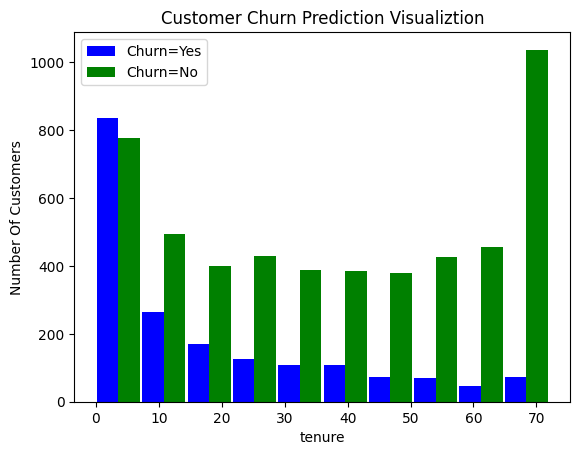

In [273]:
tenure_churn_no = df[df.Churn=='No'].tenure
tenure_churn_yes = df[df.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['blue','green'],label=['Churn=Yes','Churn=No'])
plt.legend()


Displaying the countplots for all other features except (Churn, TotalCharges, MonthlyCharges and tenure)

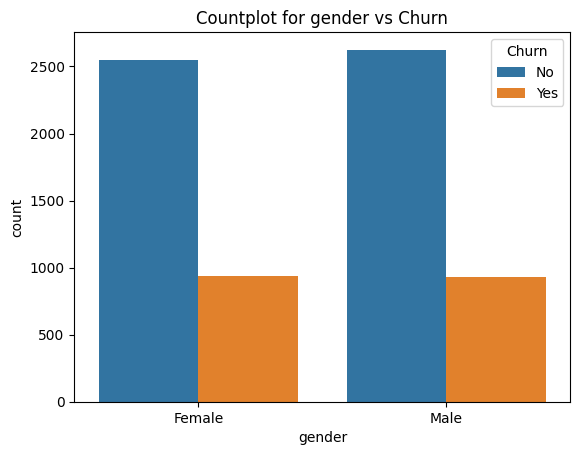

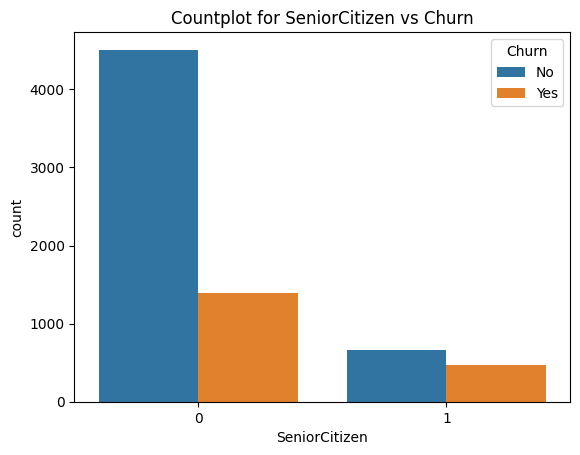

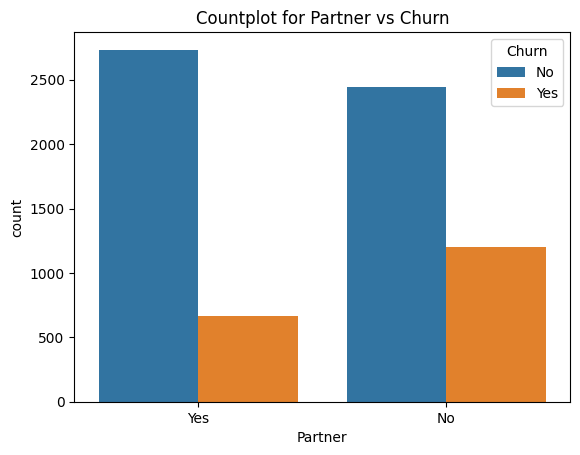

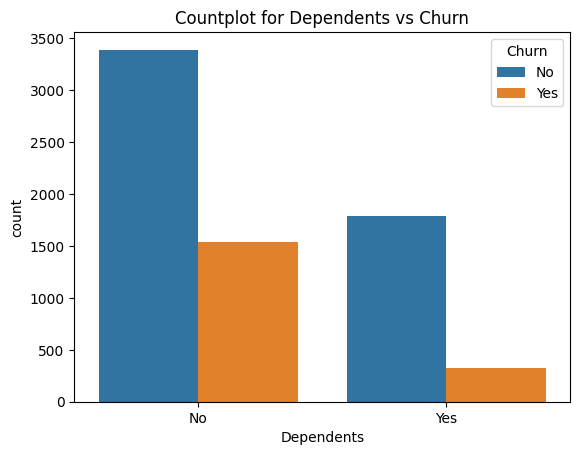

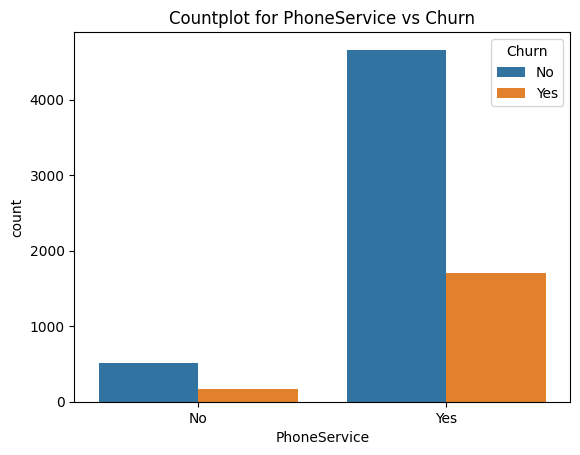

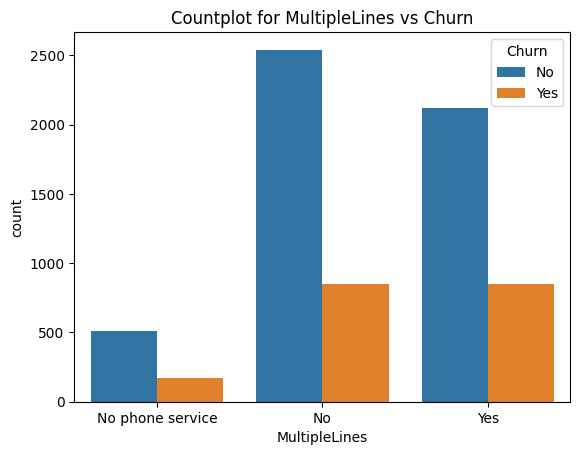

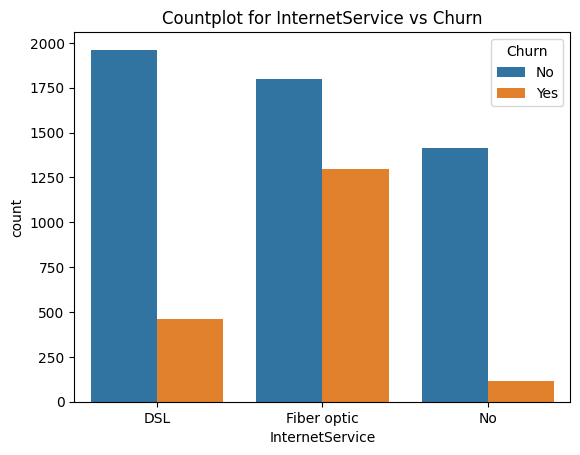

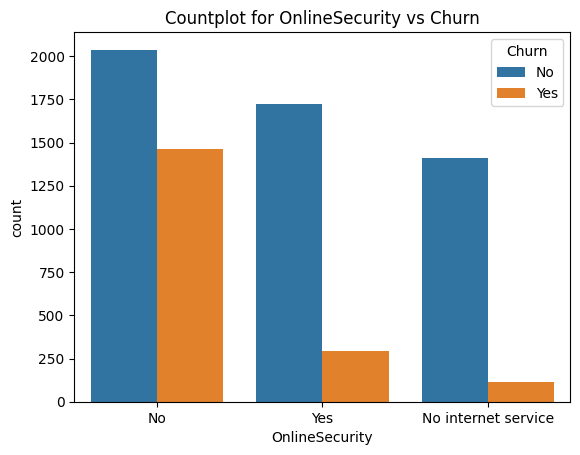

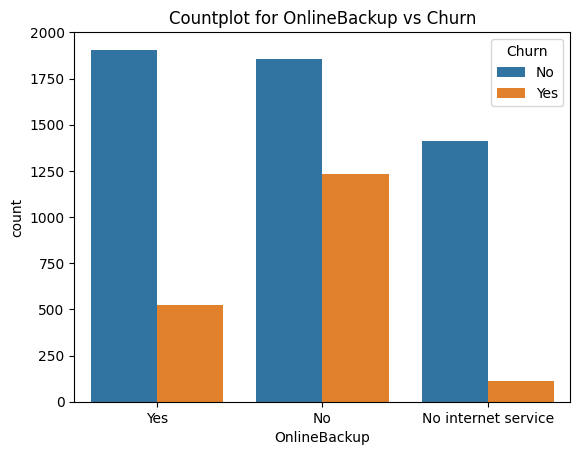

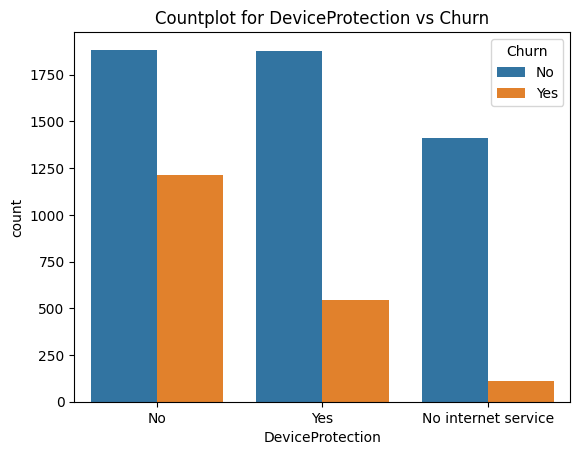

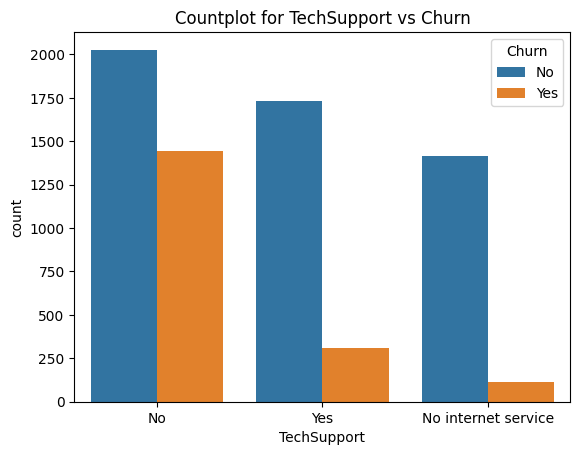

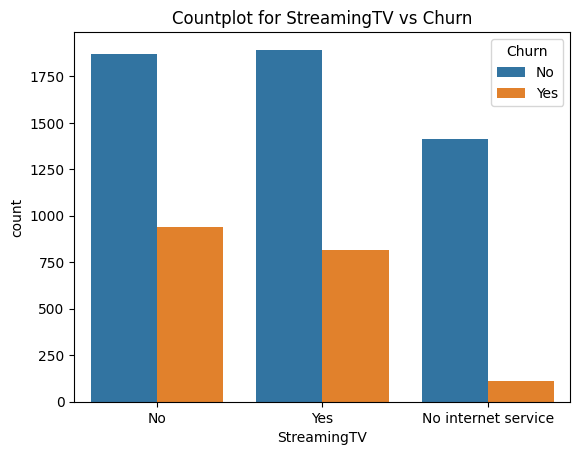

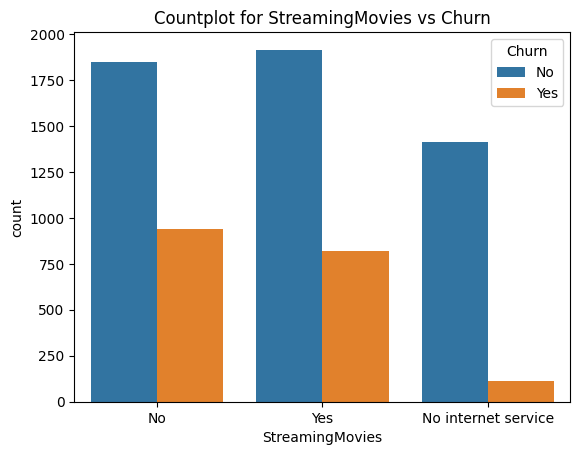

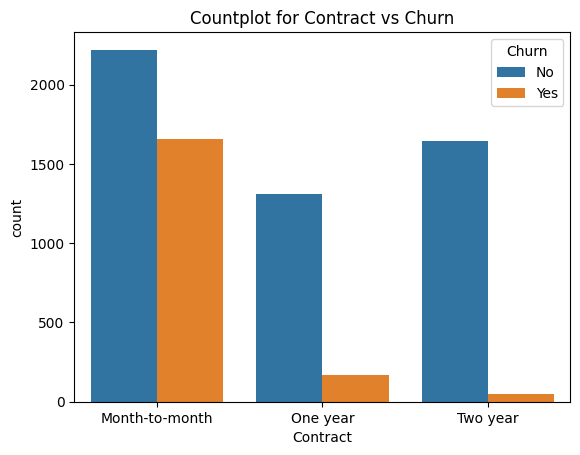

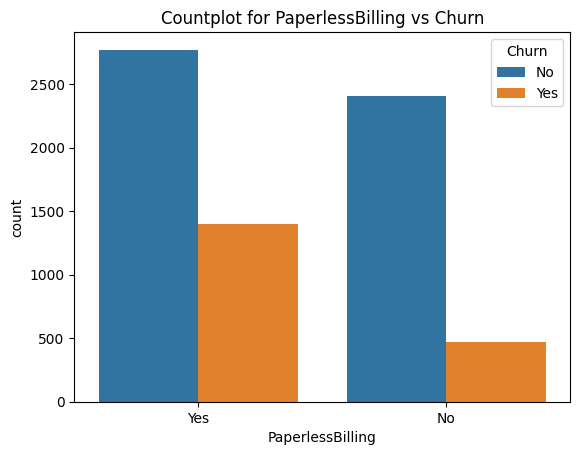

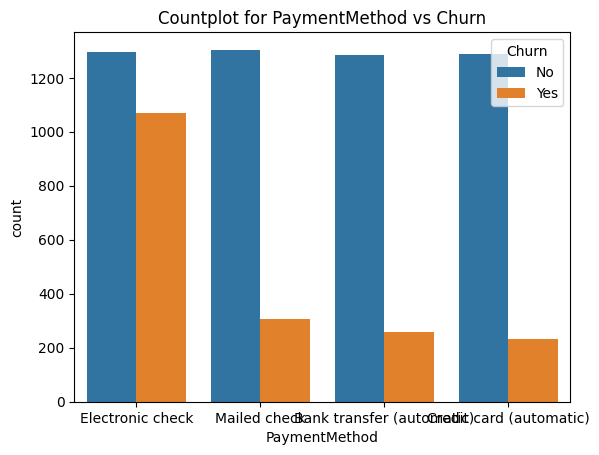

In [274]:
for i, determinant in enumerate(df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges','tenure'])):
    plt.figure(i)
    sns.countplot(data=df, x=determinant, hue='Churn')
    plt.title(f"Countplot for {determinant} vs Churn")
    plt.show()

## Question 3

Using the features in (1) define and train a Multi-Layer Perceptron model using the Functional API

Spliting data to train and test model

In [284]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Splitting the data into training (80%), validation (10%), and testing (10%)
X_train, X_temp, Y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [285]:
pip install scikeras

Creating MLP

In [286]:
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

# Function to create the Keras model
def create_mlp_model_functional(optimizer='adam'):
    # Input layer
    input_layer = Input(shape=(X_train.shape[1],))

    # Hidden layers
    hidden_layer_1 = Dense(62, activation='relu')(input_layer)
    hidden_layer_2 = Dense(29, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(12, activation='relu')(hidden_layer_2)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(hidden_layer_3)

    # Create the functional model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [287]:
# Wrapping Keras model in a scikit-learn compatible classifier
keras_clf = KerasClassifier(build_fn=create_mlp_model_functional, epochs=100, batch_size=32, verbose=0)


In [288]:
# Defining the parameter grid for GridSearchCV
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'optimizer': ['adam', 'sgd']
}

# Defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Creating GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp_model_gs = GridSearchCV(estimator=keras_clf, param_grid=param_grid, scoring='accuracy', cv=cv, verbose=1)




In [289]:
# Fitting the model using the training data and use the validation data for early stopping
mlp_model_gs.fit(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=[early_stopping])

# Getting the best parameters
best_params = mlp_model_gs.best_params_
print(f"Best parameters: {best_params}")

# Getting the best model
best_model = mlp_model_gs.best_estimator_.model

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Best parameters: {'batch_size': 32, 'epochs': 20, 'optimizer': 'sgd'}


In [290]:
mlp_model_gs.best_params_
best_model = mlp_model_gs.best_estimator_.model
y_pred = mlp_model_gs.predict(X_test)

# Question 4

Evaluate the model’s accuracy and calculate the AUC score

In [294]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming mlp_model_gs is already fitted and best_model is obtained
y_pred_proba =mlp_model_gs.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1

# Calculate AUC-ROC
auc_roc = roc_auc_score(Y_test, y_pred_proba)
print(f'AUC: {auc_roc}')

accuracy = accuracy_score(Y_test, y_pred)
print(f'Test Accuracy: {accuracy}')


AUC-ROC: 0.8725733938301531
Test Accuracy: 0.8099290780141843


# Fine-tuning and retesting

In [305]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer_1 = Dense(32, activation='elu')(input_layer)
hidden_layer_2 = Dense(24, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(12, activation='relu')(hidden_layer_2)
output_layer = Dense(1, activation='sigmoid')(hidden_layer_3)

model2 = Model(inputs=input_layer, outputs=output_layer)

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [306]:
model2.fit(X_train, Y_train,epochs =100, batch_size= 32, validation_data=(X_val, Y_val))

Epoch 1/100
177/177 [==============================] - 2s 4ms/step - loss: 0.7204 - accuracy: 0.3594 - val_loss: 0.6821 - val_accuracy: 0.6009
Epoch 2/100
177/177 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.7281 - val_loss: 0.6228 - val_accuracy: 0.7841
Epoch 3/100
177/177 [==============================] - 0s 3ms/step - loss: 0.5867 - accuracy: 0.7796 - val_loss: 0.5398 - val_accuracy: 0.7855
Epoch 4/100
177/177 [==============================] - 0s 3ms/step - loss: 0.5072 - accuracy: 0.7794 - val_loss: 0.4750 - val_accuracy: 0.7798
Epoch 5/100
177/177 [==============================] - 0s 3ms/step - loss: 0.4618 - accuracy: 0.7826 - val_loss: 0.4482 - val_accuracy: 0.7827
Epoch 6/100
177/177 [==============================] - 0s 3ms/step - loss: 0.4443 - accuracy: 0.7849 - val_loss: 0.4384 - val_accuracy: 0.7926
Epoch 7/100
177/177 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.7875 - val_loss: 0.4337 - val_accuracy: 0.7898

In [308]:
_,accuracy=model2.evaluate(X_train,Y_train)
accuracy*100

177/177 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.7989


79.88995313644409

In [309]:
loss,accuracy=model2.evaluate(X_test,Y_test)
print(f'Test loss: {loss}')
print(f'Accuracy: {accuracy*100}')

23/23 [==============================] - 0s 2ms/step - loss: 0.3845 - accuracy: 0.8199
Test loss: 0.3845256268978119
Accuracy: 81.98581337928772


,tenure,OnlineSecurity,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
381,-1.277445,0.0,0.0,1.0,1.0,-0.469015,-0.985788
681,1.165777,0.0,2.0,0.0,2.0,0.300397,1.029985
4127,0.962175,0.0,2.0,0.0,1.0,-1.328164,-0.379321
6737,1.247218,0.0,2.0,0.0,2.0,1.478611,2.012549
286,-0.503758,0.0,0.0,0.0,0.0,-0.678402,-0.598784
...,...,...,...,...,...,...,...
5022,1.572981,1.0,2.0,1.0,3.0,1.480273,2.428229
538,1.491540,0.0,1.0,0.0,3.0,1.026602,1.969632
3238,-0.259435,0.0,2.0,1.0,3.0,-1.499330,-0.789637
3260,-0.055834,0.0,0.0,0.0,0.0,0.454944,0.067047


Saving model

In [314]:
model2.save("model2.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving scaler

In [315]:
import pickle
with open('scaler.pkl', 'wb') as file:
  pickle.dump(scaler, file)